In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
from tensorflow.python.ops import io_ops
from matplotlib import pyplot as plt
import os
%matplotlib 

Using matplotlib backend: nbAgg


In [2]:
sess = tf.InteractiveSession()

In [80]:
FLAGS = {}
#FLAGS['dataset_dir'] = r"/mnt/6A0850980850655B/Datasets/commnads/audio"
#FLAGS['dataset_dir'] = r"/tmp/speech_dataset"
FLAGS['dataset_dir'] = r"C:/users/sebas/Desktop/audio-dev"
FLAGS['wanted_words'] = set(['nine', 'seven'])
FLAGS['background_dir'] = "_background_noise_"
FLAGS['clip_time_ms'] = 1500
FLAGS['window_time_ms'] = 30
FLAGS['window_stride_ms'] = 10
FLAGS['batch_size'] = 2
FLAGS['sampling_rate'] = 16000
FLAGS['mel_num_bins'] = 40
FLAGS['mel_f_min'] = 40
FLAGS['mel_f_max'] = FLAGS['sampling_rate']/2

In [81]:
def play_audio(fs, data):
    from io import BytesIO
    from scipy.io import wavfile
    import pyaudio 
    import wave  
    
    if data.dtype == np.float32:
        if np.max(np.abs(data)) > 1.0:
            raise RuntimeError("Float shoud be in range[-1,1]")
        data = (data*(1<<15)).astype(np.int16)
    elif data.dtype == np.int16:
        pass
    else:
        raise RuntimeError("Data type unsupported")
        
    with BytesIO() as buffer:
        p = pyaudio.PyAudio()
        wavfile.write(buffer, fs, data)
        f = wave.open(buffer,"rb")  
        #define stream chunk   
        chunk = 1024  
        
        stream = p.open(format = p.get_format_from_width(f.getsampwidth()),  
                        channels = f.getnchannels(),  
                        rate = f.getframerate(),  
                        output = True)  
        
        #read data  
        audio_data = f.readframes(chunk)


        #play stream  
        while audio_data:  
            stream.write(audio_data)  
            audio_data = f.readframes(chunk)  

        #stop stream  
        stream.stop_stream()  
        stream.close()  
        p.terminate()

In [82]:
def get_model_settings(clip_time_ms, sampling_rate, window_time_ms, window_stride_time_ms, mel_f_min, mel_f_max, mel_num_bins):
    clip_samples = int(clip_time_ms * sampling_rate / 1000)
    window_samples = int(window_time_ms * sampling_rate / 1000)
    window_stride_samples = int(window_stride_time_ms * sampling_rate / 1000)
    length_in_samples = 1 + int((clip_samples - window_samples) / window_stride_samples)
    fft_size = int(2**np.ceil(np.log2(window_samples)))
    settings = {
        'clip_samples':          clip_samples,
        'window_samples':        window_samples,
        'window_stride_samples':window_stride_samples,
        'fingerprint_size':      length_in_samples*mel_num_bins,
        'sampling_rate':         sampling_rate,
        'mel_f_min':             mel_f_min,
        'mel_f_max':             mel_f_max,
        'mel_num_bins':          mel_num_bins,
        'fft_size':              fft_size
    }
    return settings
    

In [83]:
class AudioProcessor:
    def __init__(self, dataset_dir, background_dir, wanted_words, model_settings, batch_size):
        all_paths, all_labels = self.load_audio(wanted_words, dataset_dir, background_dir)
        self.model_settings = model_settings
        self.dataset = self.prepare_processing_graph(all_paths, all_labels, batch_size)
        self.iter = self.dataset.make_one_shot_iterator()
        self.mel_matrix = tf.constant(self.prepare_to_mel_matrix())
        
    def prepare_to_mel_matrix(self):
        mel_num_bins = self.model_settings['mel_num_bins']
        mel_f_min = self.model_settings['mel_f_min']
        mel_f_max = self.model_settings['mel_f_max']
        num_spectrogram_bins = self.model_settings['fft_size']//2+1
        fs = self.model_settings['sampling_rate']

        linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
          mel_num_bins, num_spectrogram_bins, fs, mel_f_min, mel_f_max)
        return linear_to_mel_weight_matrix.eval()
        
    def prepare_processing_graph(self, all_paths, all_labels, batch_size):
        clip_samples = self.model_settings['clip_samples']
        
        #TODO check expected fs
        def process_single_file(path):
            wav_loader = io_ops.read_file(path)
            audio, fs = contrib_audio.decode_wav(wav_loader, desired_channels=1, desired_samples=clip_samples)
            audio = tf.squeeze(audio)
            return audio
        
        dataset = tf.data.Dataset.from_tensor_slices(
                    tf.convert_to_tensor(all_paths))
        dataset = dataset.map(process_single_file)
        
        labels_dataset = tf.data.Dataset.from_tensor_slices(
                    tf.convert_to_tensor(all_labels))
        
        #add labels to dataset
        dataset = tf.data.Dataset.zip((dataset, labels_dataset))
        dataset = dataset.batch(batch_size)
        return dataset

        
    def load_audio(self, wanted_words, dataset_dir, background_dir):
        """
            Finds all wave files in dataset directory and arranges them into word -> list of files
        """
        all_paths = []
        all_labels = []
        search_path = os.path.join(dataset_dir, '*', '*.wav')
        for wav_path in gfile.Glob(search_path):
            _, word = os.path.split(os.path.dirname(wav_path))
            if word == background_dir:
                continue
            if word in wanted_words:
                all_paths.append(wav_path)
                all_labels.append(word)
#         all_paths = ['/media/sebastian/Itanos/Kursy/Audio signal processing coursera/sounds/piano.wav',
#                      '/media/sebastian/Itanos/Kursy/Audio signal processing coursera/sounds/sine-440.wav']
#         all_paths = ['I:/Kursy/Audio signal processing coursera/sounds/piano.wav',
#                      'I:/Kursy/Audio signal processing coursera/sounds/sine-440.wav']
#         all_labels = ['piano', 'sine']
        return all_paths, all_labels
    
    def get_data(self, want_raw_spect: bool = False):
        """
            Applies random transforms, and returns audio as spectrograms
        """
        signals, labels = self.iter.get_next()
        frame_len = self.model_settings['window_samples']
        frame_step = self.model_settings['window_stride_samples']
        fft_size = self.model_settings['fft_size']
        spect = tf.contrib.signal.stft(signals, frame_len, frame_step, fft_size)
        spect_mag = tf.abs(spect)
        mel_spect = tf.tensordot(spect_mag, self.mel_matrix, 1)
        if want_raw_spect:
            return mel_spect, labels, spect
        else:
            return mel_spect, labels

model_settings = get_model_settings(FLAGS['clip_time_ms'], FLAGS['sampling_rate'], FLAGS['window_time_ms'],
                                    FLAGS['window_stride_ms'], FLAGS['mel_f_min'], FLAGS['mel_f_max'], FLAGS['mel_num_bins'])
ap = AudioProcessor(FLAGS['dataset_dir'], FLAGS['background_dir'], FLAGS['wanted_words'], model_settings, FLAGS['batch_size'])

In [88]:
def reconstruct_audio_from_mel(mel_spect, model_settings, true_spect = None):
    mel_inv = np.linalg.pinv(ap.mel_matrix.eval())
    spect_mag_reconstructed = (mel_spect @ mel_inv)
    
    if true_spect is not None:
        phase = tf.angle(tf.constant(true_spect))
    else:
        phase = tf.random_uniform(spect_mag_reconstructed.shape, 2 * np.pi)
        
    spect_reconstructed = tf.complex(spect_mag_reconstructed * tf.cos(phase), spect_mag_reconstructed * tf.sin(phase))
    audio = tf.contrib.signal.inverse_stft(spect_reconstructed, model_settings['window_samples'], 
                                           model_settings['window_stride_samples'], model_settings['fft_size'])
    return audio.eval()

In [95]:
spectras, labels, spectras_true = ap.get_data(True)
spectras, labels, spectras_true = sess.run((spectras, labels, spectras_true))

<IPython.core.display.Javascript object>


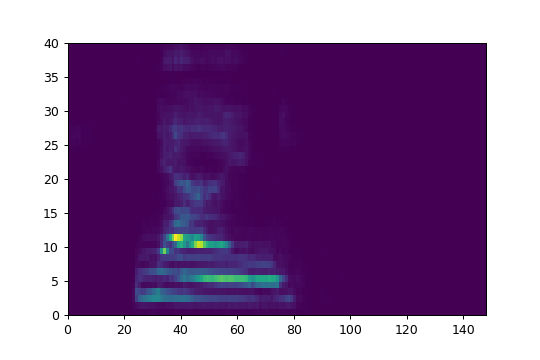

In [104]:
plt.pcolormesh(np.abs(spectras[0,:,:]).T)
plt.show()

In [97]:
print(model_settings['fingerprint_size'])
print(spectras[0,:,:].size)

5920
5920


In [103]:
play_audio(FLAGS['sampling_rate'],reconstruct_audio_from_mel(spectras[1,:,:], model_settings, spectras_true[0,:,:]))
       
# plt.plot(piano)
# plt.show()

In [100]:
num_spectrogram_bins = spectras.shape[-1]
sample_rate = 44100
lower_edge_hertz, upper_edge_hertz, num_mel_bins = 40.0, 8000.0, 20
linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
  num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
  upper_edge_hertz)
spect = tf.constant(spectras)
mel_spect = tf.tensordot(spect, linear_to_mel_weight_matrix, 1)
linear_to_mel_weight_matrix, mel_spect = sess.run((linear_to_mel_weight_matrix,mel_spect))
print(linear_to_mel_weight_matrix.shape)
# mel_spectrograms = tf.tensordot(
#   magnitude_spectrograms, linear_to_mel_weight_matrix, 1)
# # Note: Shape inference for `tf.tensordot` does not currently handle this case.
# mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(
#   linear_to_mel_weight_matrix.shape[-1:]))

(513, 20)


In [45]:
spectras.shape

(2, 255, 513)

In [46]:
a.shape

(513, 64)

<IPython.core.display.Javascript object>


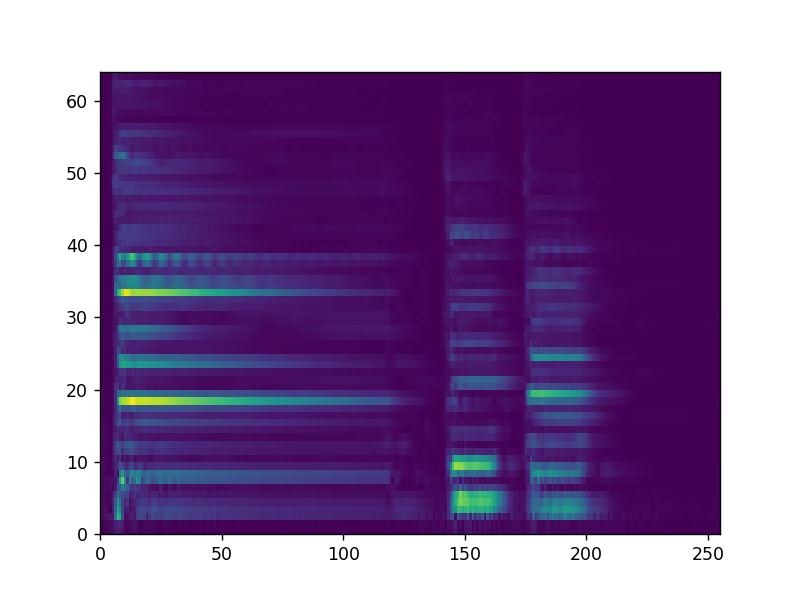

In [55]:
plt.pcolormesh(mel_spect[0,:,:].T)
plt.show()

<IPython.core.display.Javascript object>


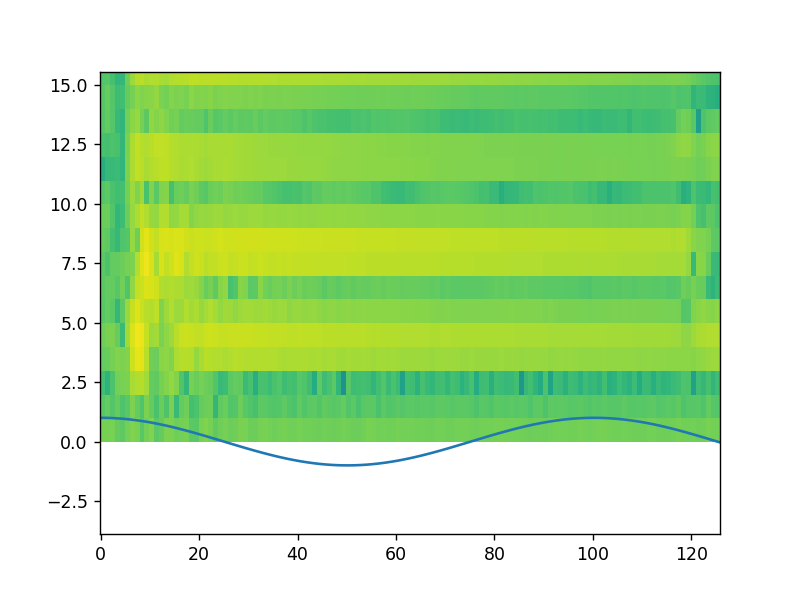

In [56]:
plt.pcolormesh(np.log(spectras[0,:,:].T))
plt.show()
#spectras.shape

[  0   1   3   5   7   9  11  13  16  19  22  25  29  33  37  42  47  53
  59  65  73  80  89  98 108 120 132 145 159 174 191 210 230 252 275 301
 329 360 393 429 469 512]


<IPython.core.display.Javascript object>


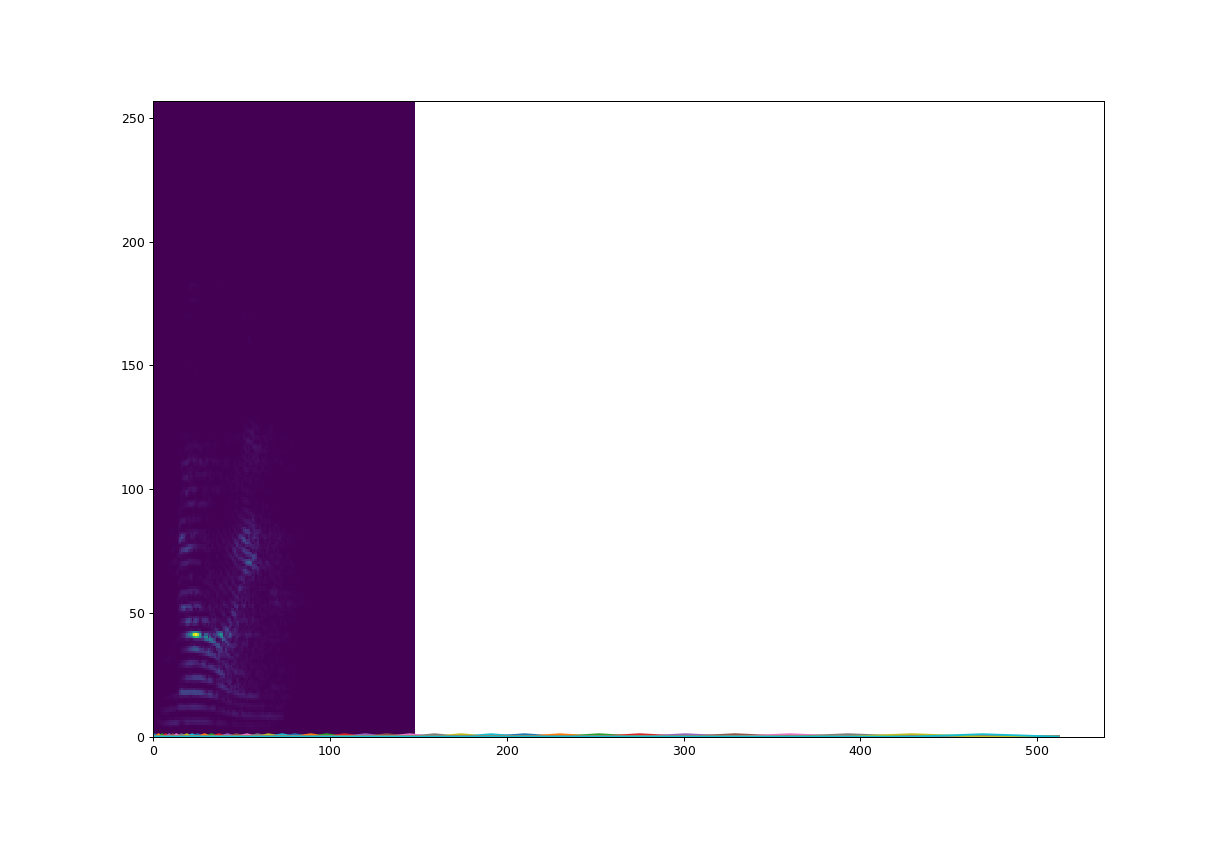

In [114]:
#Generate Mel Filter Bank
min_f_hz = 0
max_f_hz = fs/2
n_filters = 40

def to_mel(f): return 2595*np.log10(1+f/700)
def to_hz(f): return (10**(f/2595)-1)*700


min_f_mel = to_mel(min_f_hz)
max_f_mel = to_mel(max_f_hz)
mel_points = np.linspace(min_f_mel, max_f_mel, n_filters+2)
mel_points_hz = to_hz(mel_points)
fft_bins = np.floor((fft_size+0)*mel_points_hz/fs)
print(fft_bins)

fbank = np.zeros((n_filters, fft_size//2+1))
for m in range(1, n_filters+1):
    f_m_minus = int(fft_bins[m - 1])   # left
    f_m = int(fft_bins[m])             # center
    f_m_plus = int(fft_bins[m + 1])    # right
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - fft_bins[m - 1]) / (fft_bins[m] - fft_bins[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (fft_bins[m + 1] - k) / (fft_bins[m + 1] - fft_bins[m])
        
for i in range(fbank.shape[0]):
    plt.plot(fbank[i,:])
plt.show()

[  0.   1.   3.   4.   6.   8.  10.  13.  15.  18.  21.  25.  28.  32.
  37.  41.  46.  52.  58.  65.  72.  80.  88.  98. 108. 119. 131. 144.
 158. 174. 191. 209. 229. 251. 275. 301. 329. 359. 393. 429. 468. 512.]


In [48]:
def f(a:bool = True):
    pass
f(1)